In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from data_repository import DataRepository
from model_training_ultils import ModelMemCalculation
from model_training_ultils import ModelEvaluationUltis

# Import data

In [2]:
mem_cal = ModelMemCalculation()
evaludation_tool = ModelEvaluationUltis()

In [3]:
data_repo = DataRepository("../.env")
#Clean data
train_ampls, y_train, validation_ampls, y_validation, test_ampls, y_test = data_repo.load_fft_data(clean_data=True)

In [4]:
print(f"Train dataset: X: {train_ampls.shape}, y: {y_train.shape}")
print(f"Validation dataset: X: {validation_ampls.shape}, y: {y_validation.shape}")
print(f"Test dataset: X: {test_ampls.shape}, y: {y_test.shape}")

Train dataset: X: (8188, 4501), y: (8188,)
Validation dataset: X: (1123, 4501), y: (1123,)
Test dataset: X: (2012, 4501), y: (2012,)


__Label encoder__

In [5]:
# Chuyển đổi danh sách labels thành mã số
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)
y_test = label_encoder.transform(y_test)

In [6]:
print(list(label_encoder.classes_))
print(label_encoder.transform(list(label_encoder.classes_)))

['error', 'normal', 'overcurrent', 'overheating', 'zero']
[0 1 2 3 4]


# Feature selection

## Finding top 50 highest amplitudes

In [7]:
def find_top_k_indices(amplitudes, k):
    # Get the indices of the top 50 elements
    top_k_indices = np.argsort(amplitudes)[-k:][::-1]
    highest_ampls = amplitudes[top_k_indices]
    return highest_ampls

def get_x_by_top_ampls(k, ampls):
    X = []
    for ampl in ampls:
        X.append(find_top_k_indices(amplitudes=ampl, k=k))
    return np.array(X)

__Optimal k from validation set__
- k SVM = 454
- k RF = 12
- k XgBoost = 249

In [8]:
k_svm = 1
k_rf = 1
k_xgb = 1

X_train_SVM = get_x_by_top_ampls(k=k_svm, ampls=train_ampls)
X_validation_SVM = get_x_by_top_ampls(k=k_svm, ampls=validation_ampls)
X_test_SVM = get_x_by_top_ampls(k=k_svm, ampls=test_ampls)

X_train_RF = get_x_by_top_ampls(k=k_rf, ampls=train_ampls)
X_validation_RF = get_x_by_top_ampls(k=k_rf, ampls=validation_ampls)
X_test_RF = get_x_by_top_ampls(k=k_rf, ampls=test_ampls)

X_train_XgBoost = get_x_by_top_ampls(k=k_xgb, ampls=train_ampls)
X_validation_XgBoost = get_x_by_top_ampls(k=k_xgb, ampls=validation_ampls)
X_test_XgBoost = get_x_by_top_ampls(k=k_xgb, ampls=test_ampls)

In [9]:
print(X_train_SVM.shape, X_validation_SVM.shape, X_test_SVM.shape)
print(X_train_RF.shape, X_validation_RF.shape, X_test_RF.shape)
print(X_train_XgBoost.shape, X_validation_XgBoost.shape, X_test_XgBoost.shape)

(8188, 1) (1123, 1) (2012, 1)
(8188, 1) (1123, 1) (2012, 1)
(8188, 1) (1123, 1) (2012, 1)


# Model training

## SVM

### Xây dựng mô hình

In [10]:
from sklearn.svm import SVC
svm_fft = SVC(kernel='rbf', random_state=42, probability=True)
svm_fft.fit(X_train_SVM, y_train)

SVC(probability=True, random_state=42)

In [11]:
svm_y_pred_val = svm_fft.predict(X_validation_SVM)
svm_y_pred_proba_val = svm_fft.predict_proba(X_validation_SVM)

              precision    recall  f1-score   support

       error       0.84      0.84      0.84       231
      normal       0.99      0.97      0.98       229
 overcurrent       0.98      1.00      0.99       220
 overheating       0.83      0.96      0.89       200
        zero       1.00      0.88      0.93       243

    accuracy                           0.93      1123
   macro avg       0.93      0.93      0.93      1123
weighted avg       0.93      0.93      0.93      1123


Custom reports
Precision: 0.929580212058473
Recall: 0.9300338352681875
Accuracy: 0.9278717720391808
F1-Score (Macro): 0.9280360476112222
Macro-average AUC (SVM): 0.9965920029648577


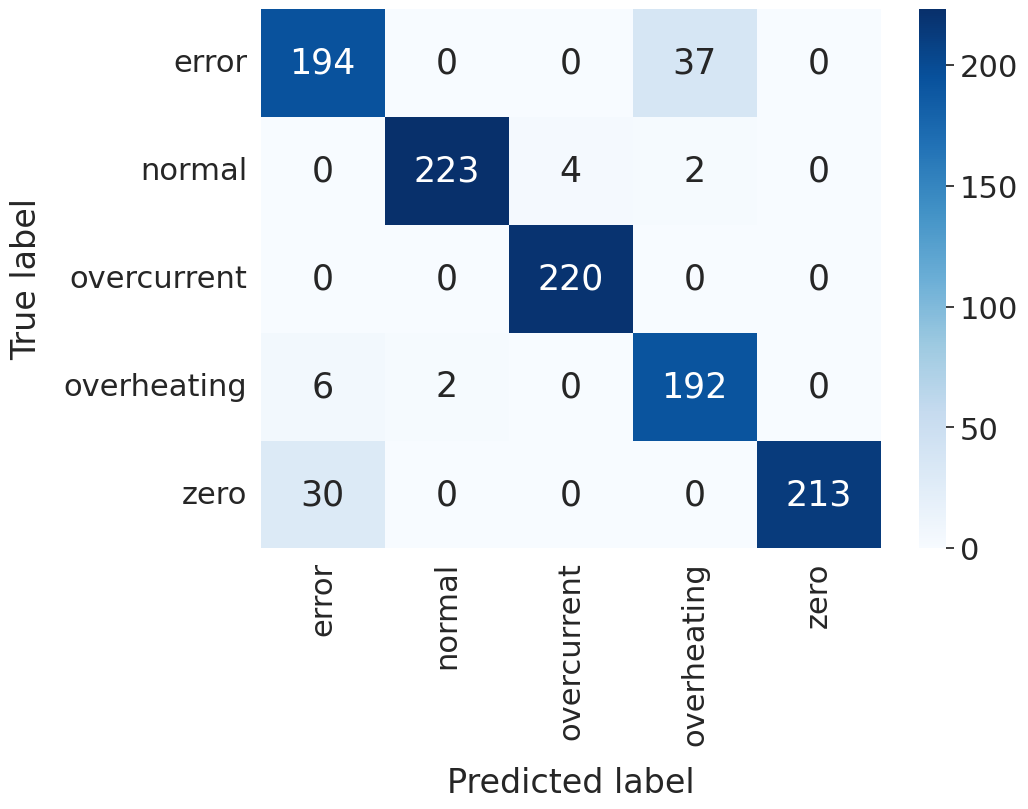

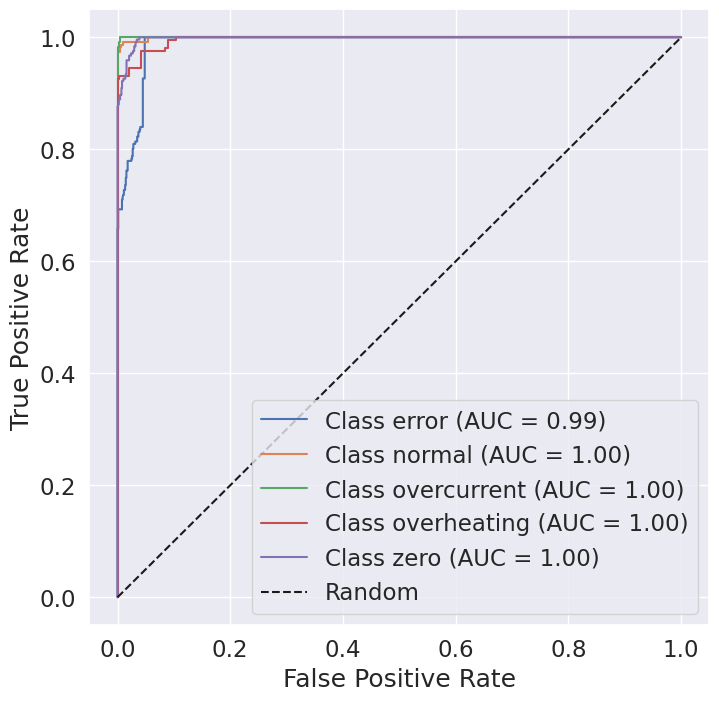

In [12]:
svm_conf_val = evaludation_tool.evaluate_and_print_results(y_pred=svm_y_pred_val, y_pred_proba=svm_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder) 
evaludation_tool.plot_conf_matrix(svm_conf_val)
evaludation_tool.plot_auc_curve(y_test=y_validation, y_pred_proba=svm_y_pred_proba_val, label_encoder=label_encoder)

In [13]:
svm_y_pred = svm_fft.predict(X_test_SVM)
svm_y_pred_proba = svm_fft.predict_proba(X_test_SVM)

              precision    recall  f1-score   support

       error       0.90      0.85      0.87       414
      normal       0.97      0.99      0.98       394
 overcurrent       1.00      1.00      1.00       421
 overheating       0.84      0.94      0.89       374
        zero       1.00      0.92      0.96       409

    accuracy                           0.94      2012
   macro avg       0.94      0.94      0.94      2012
weighted avg       0.94      0.94      0.94      2012


Custom reports
Precision: 0.9416283677342108
Recall: 0.9411154616157382
Accuracy: 0.9408548707753479
F1-Score (Macro): 0.9403788324078471
Macro-average AUC (SVM): 0.9973275226362919


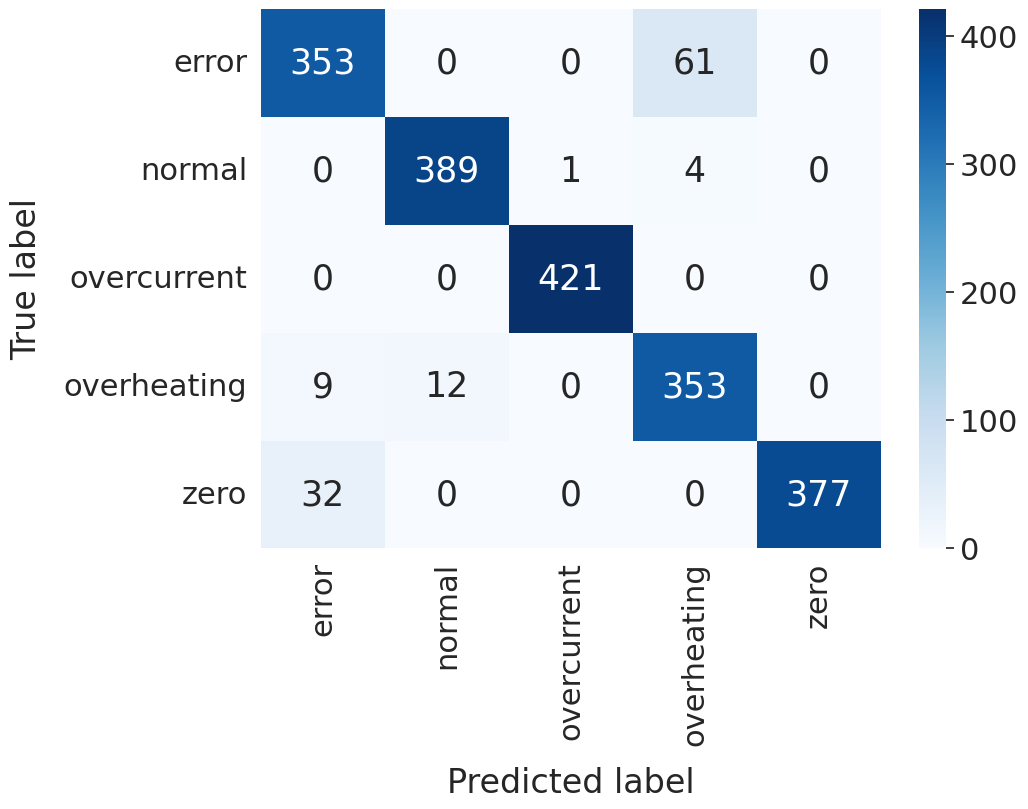

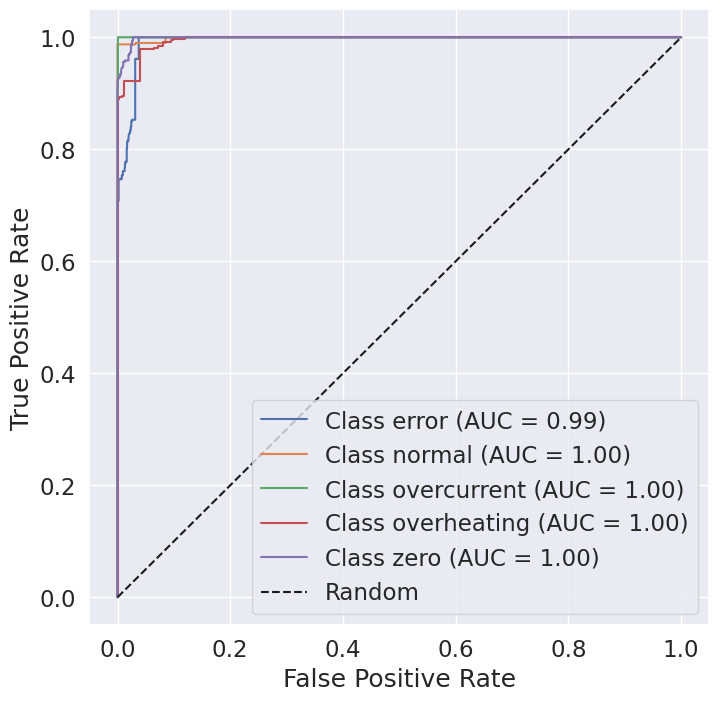

In [14]:
svm_conf = evaludation_tool.evaluate_and_print_results(y_pred=svm_y_pred, y_pred_proba=svm_y_pred_proba, y_test=y_test, label_encoder=label_encoder) 
evaludation_tool.plot_conf_matrix(svm_conf)
evaludation_tool.plot_auc_curve(y_test=y_test, y_pred_proba=svm_y_pred_proba, label_encoder=label_encoder)

## Random Forest

### Xây dựng mô hình

In [12]:
# Tạo mô hình RF
import time
start_time = time.time()
from sklearn.ensemble import RandomForestClassifier
rf_fft = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_fft.fit(X_train_RF, y_train)
end_time = time.time()
print(end_time - start_time)

0.2529337406158447


In [16]:
rf_y_pred_val = rf_fft.predict(X_validation_RF)
rf_y_pred_proba_val = rf_fft.predict_proba(X_validation_RF)

              precision    recall  f1-score   support

       error       0.91      0.94      0.92       231
      normal       1.00      0.99      0.99       229
 overcurrent       0.99      1.00      0.99       220
 overheating       1.00      1.00      1.00       200
        zero       0.94      0.91      0.92       243

    accuracy                           0.96      1123
   macro avg       0.97      0.97      0.97      1123
weighted avg       0.96      0.96      0.96      1123


Custom reports
Precision: 0.9661101576755957
Recall: 0.9662859037919688
Accuracy: 0.9643811219946572
F1-Score (Macro): 0.9660998135017722
Macro-average AUC (SVM): 0.9967140047771356


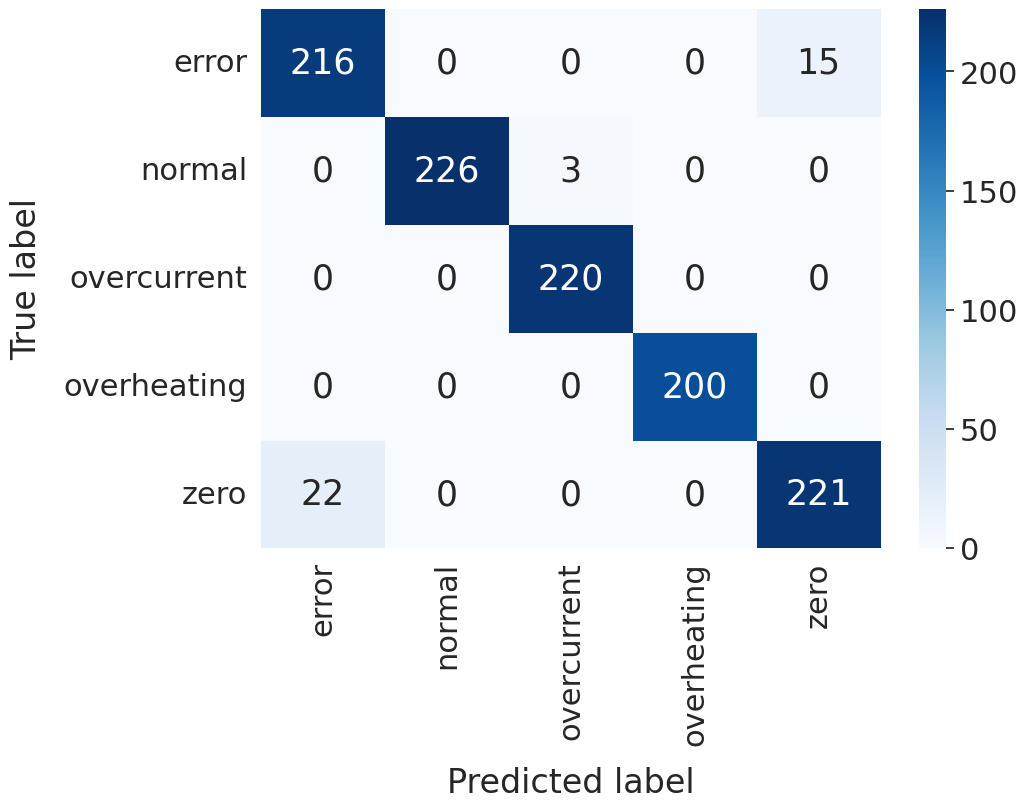

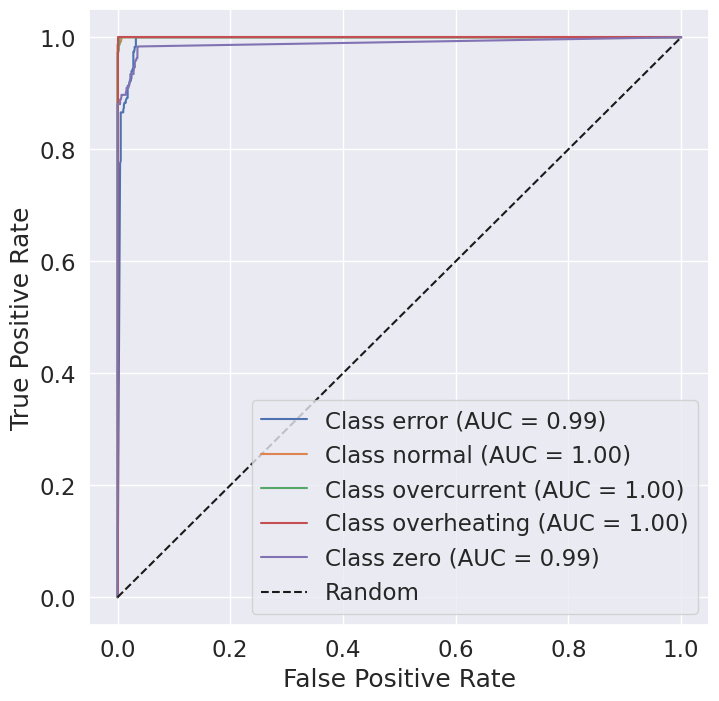

In [17]:
rf_val_cm = evaludation_tool.evaluate_and_print_results(y_pred=rf_y_pred_val, y_pred_proba=rf_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
evaludation_tool.plot_conf_matrix(conf_matrix=rf_val_cm)
evaludation_tool.plot_auc_curve(y_pred_proba=rf_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

__Test set__

In [18]:
rf_y_pred = rf_fft.predict(X_test_RF)
rf_y_pred_proba = rf_fft.predict_proba(X_test_RF)

              precision    recall  f1-score   support

       error       0.95      0.96      0.95       414
      normal       0.98      1.00      0.99       394
 overcurrent       1.00      0.98      0.99       421
 overheating       1.00      1.00      1.00       374
        zero       0.96      0.95      0.95       409

    accuracy                           0.98      2012
   macro avg       0.98      0.98      0.98      2012
weighted avg       0.98      0.98      0.98      2012


Custom reports
Precision: 0.9756812824139557
Recall: 0.9757441402207409
Accuracy: 0.9751491053677932
F1-Score (Macro): 0.9756357284848101
Macro-average AUC (SVM): 0.998617929096732


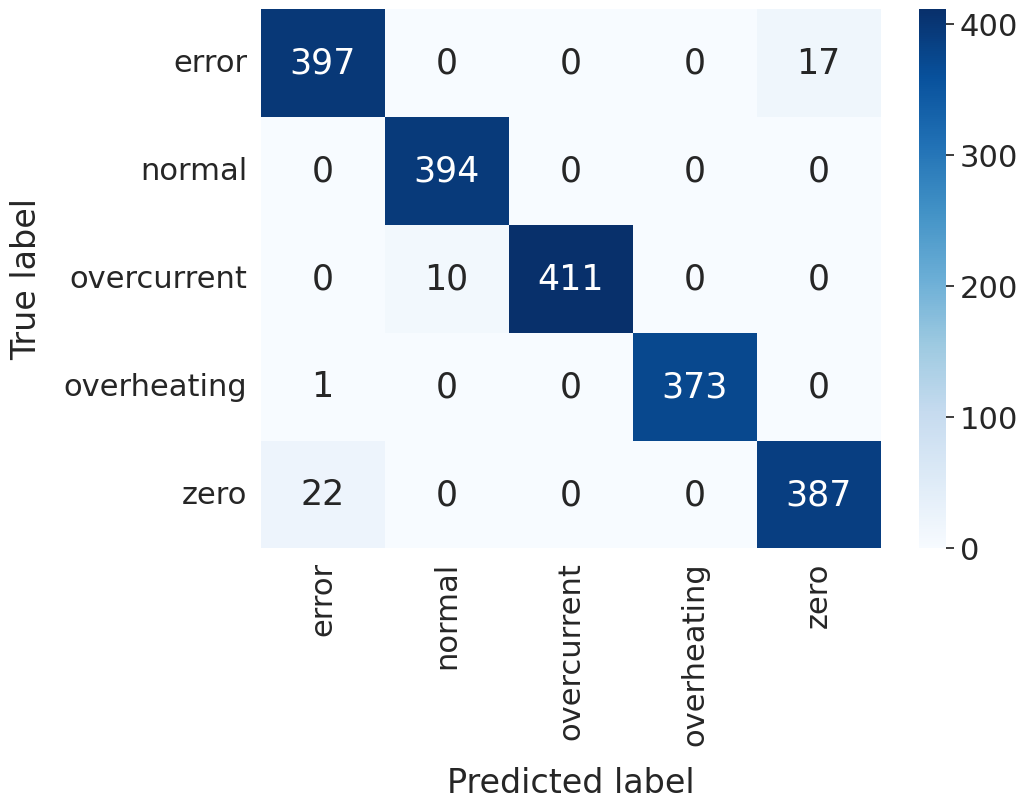

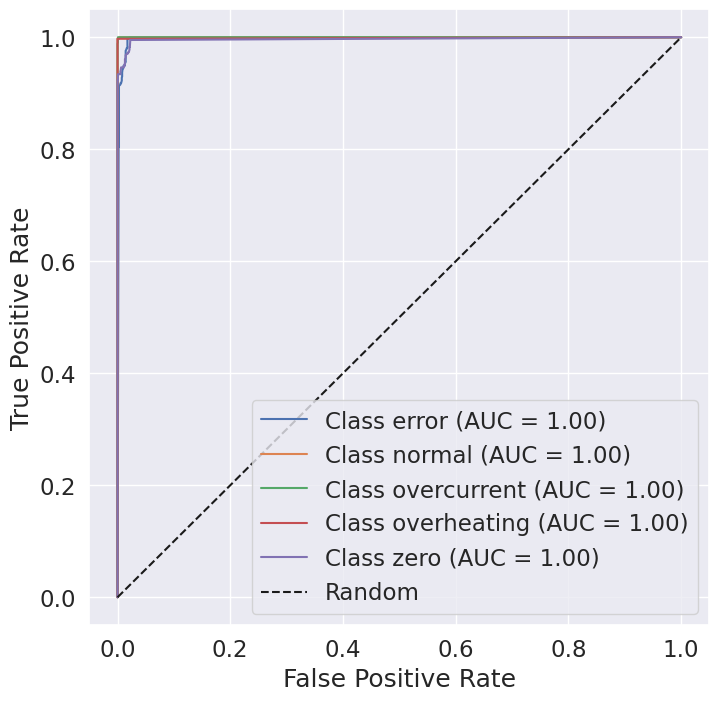

In [19]:
rf_cm = evaludation_tool.evaluate_and_print_results(y_pred=rf_y_pred, y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
evaludation_tool.plot_conf_matrix(conf_matrix=rf_cm)
evaludation_tool.plot_auc_curve(y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)

## XgBoost

### Xây dựng mô hình

In [20]:
from xgboost import XGBClassifier
xgboost_fft = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
xgboost_fft.fit(X_train_XgBoost, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

#### Validation set

In [21]:
xgb_y_pred_val = xgboost_fft.predict(X_validation_XgBoost)
xgb_y_pred_proba_val = xgboost_fft.predict_proba(X_validation_XgBoost)

              precision    recall  f1-score   support

       error       0.90      0.97      0.93       231
      normal       1.00      0.97      0.98       229
 overcurrent       0.98      1.00      0.99       220
 overheating       0.98      0.99      0.99       200
        zero       0.98      0.90      0.94       243

    accuracy                           0.96      1123
   macro avg       0.97      0.97      0.97      1123
weighted avg       0.97      0.96      0.96      1123


Custom reports
Precision: 0.9662309923606152
Recall: 0.96617124107226
Accuracy: 0.9643811219946572
F1-Score (Macro): 0.9655843994716523
Macro-average AUC (SVM): 0.9987570986409523


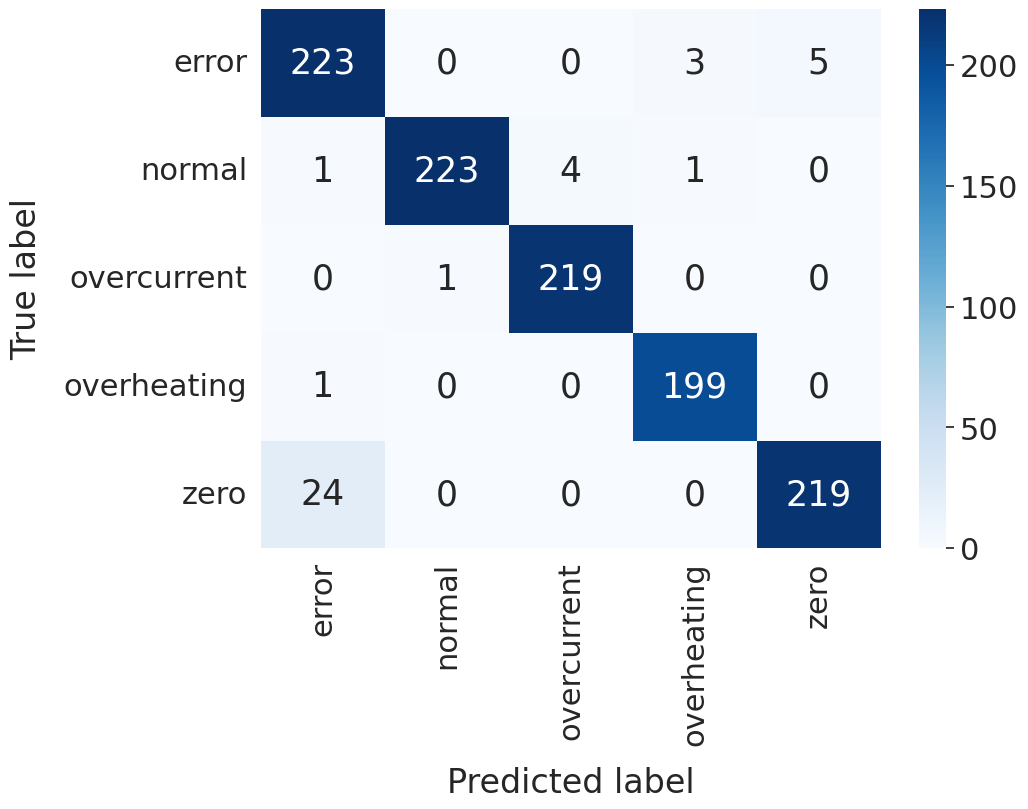

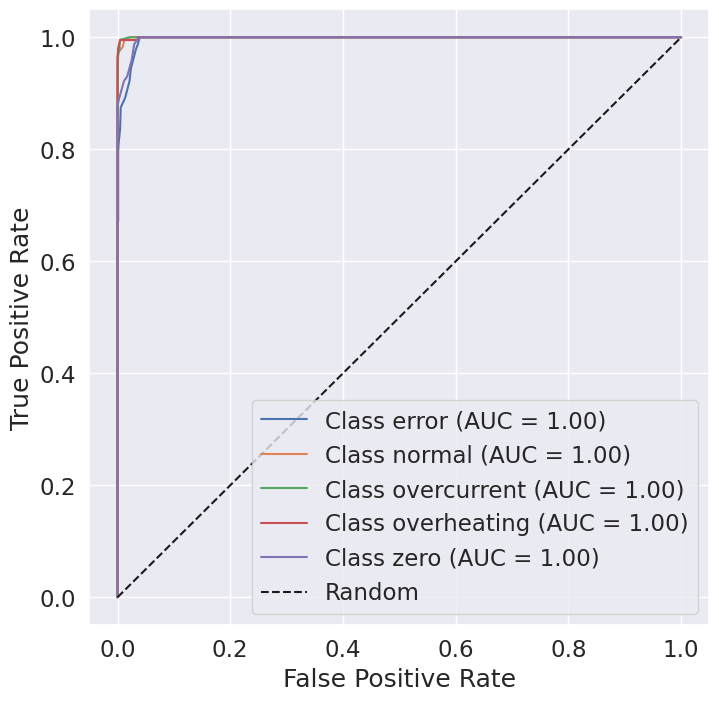

In [22]:
xgb_val_cm = evaludation_tool.evaluate_and_print_results(y_pred=xgb_y_pred_val, y_pred_proba=xgb_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
evaludation_tool.plot_conf_matrix(conf_matrix=xgb_val_cm)
evaludation_tool.plot_auc_curve(y_pred_proba=xgb_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

#### Test set

In [23]:
xgb_y_pred = xgboost_fft.predict(X_test_XgBoost)
xgb_y_pred_proba = xgboost_fft.predict_proba(X_test_XgBoost)

              precision    recall  f1-score   support

       error       0.91      0.98      0.95       414
      normal       1.00      0.99      0.99       394
 overcurrent       1.00      1.00      1.00       421
 overheating       0.99      0.98      0.98       374
        zero       0.99      0.93      0.96       409

    accuracy                           0.98      2012
   macro avg       0.98      0.98      0.98      2012
weighted avg       0.98      0.98      0.98      2012


Custom reports
Precision: 0.9767106903494369
Recall: 0.975152128845418
Accuracy: 0.9751491053677932
F1-Score (Macro): 0.9755009851596107
Macro-average AUC (SVM): 0.9991539649601293


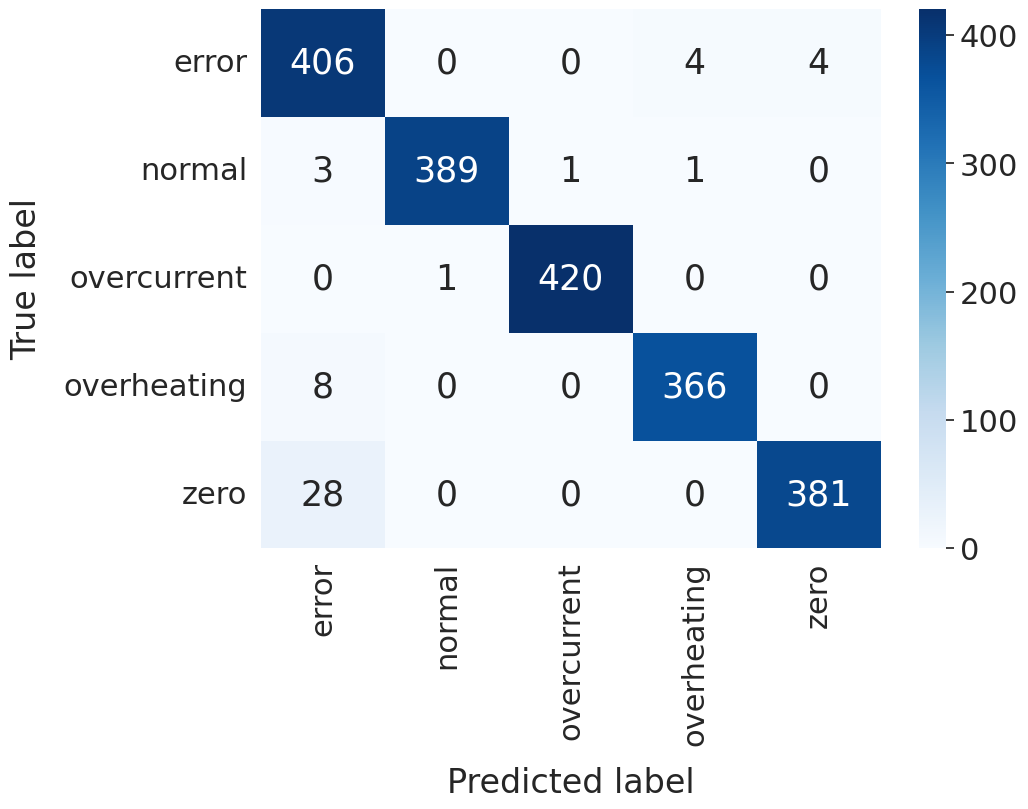

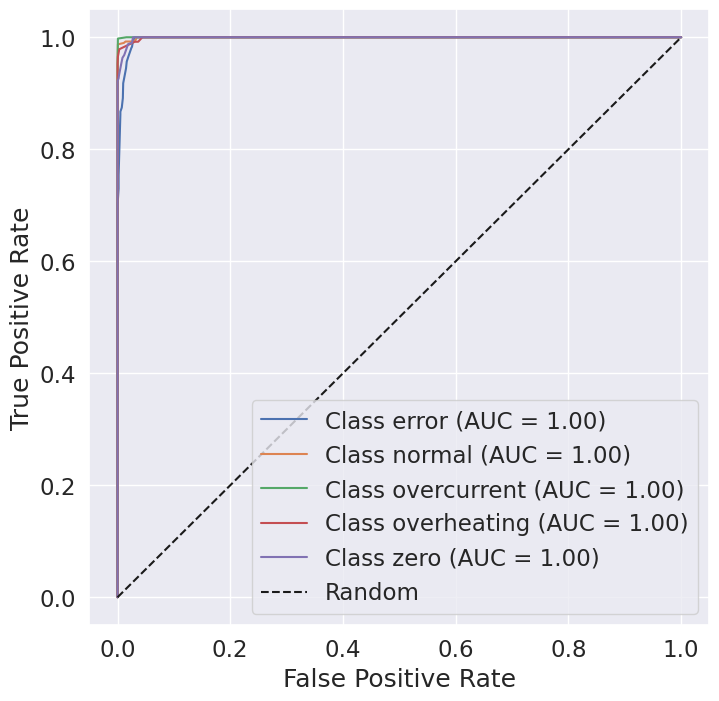

In [24]:
xgb_test_cm_test = evaludation_tool.evaluate_and_print_results(y_pred=xgb_y_pred, y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
evaludation_tool.plot_conf_matrix(conf_matrix=xgb_test_cm_test)
evaludation_tool.plot_auc_curve(y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)

# Overfitting check

In [25]:
svm_train_accuracy = accuracy_score(y_pred=svm_fft.predict(X_train_SVM), y_true=y_train)
svm_validation_accuracy = accuracy_score(y_pred=svm_y_pred_val, y_true=y_validation) 
svm_test_accuracy = accuracy_score(y_pred=svm_y_pred, y_true=y_test)
print(f"SVM train error: {1-svm_train_accuracy}, validation error: {1-svm_validation_accuracy}, test error: {1-svm_test_accuracy}")

SVM train error: 0.0582559843673669, validation error: 0.07212822796081919, test error: 0.05914512922465209


In [26]:
rf_train_accuracy = accuracy_score(y_pred=rf_fft.predict(X_train_RF), y_true=y_train)
rf_val_ac = accuracy_score(y_pred=rf_y_pred_val, y_true=y_validation)
rf_test_ac = accuracy_score(y_pred=rf_y_pred, y_true=y_test)
print(f"RF train error: {1-rf_train_accuracy}, validation error: {1-rf_val_ac}, test error: {1-rf_test_ac}")

RF train error: 0.00415241817293599, validation error: 0.0356188780053428, test error: 0.0248508946322068


In [27]:
xgb_train_accuracy = accuracy_score(y_pred=xgboost_fft.predict(X_train_XgBoost), y_true=y_train)
xgb_val_ac = accuracy_score(y_pred=xgb_y_pred_val, y_true=y_validation)
xgb_test_ac = accuracy_score(y_pred=xgb_y_pred, y_true=y_test)
print(f"XgBoost train error: {1-xgb_train_accuracy}, SVM validation error: {1-xgb_val_ac}, SVM test error: {1-xgb_test_ac}")

XgBoost train error: 0.021372740595994144, SVM validation error: 0.0356188780053428, SVM test error: 0.0248508946322068
